In [1]:
### Modified Wang model to implement a satisficing approach instead of strict optimization. 
### This follows the concept that plants don't necessarily find the absolute optimal solution, 
### but rather a "good enough" solution that meets certain criteria.
### This approach reflects how evolution works - finding solutions that are "good enough" to survive and reproduce, rather than mathematically optimal.
### Stomata aren't trying to be the "best" at anything. They are trying to avoid being catastrophically bad at any of the things essential for survival.

# Multiple Criteria: Instead of a single optimization objective, the model now considers multiple criteria:
    # Minimum safety margin (20% from E_crit)
    # Minimum photosynthesis (70% of maximum possible)
    # Maximum hydraulic risk tolerance
# Satisficing Region: The model identifies a range of "good enough" solutions rather than a single optimum.
# Relaxed Criteria: If no solutions meet all criteria, the model relaxes the constraints to find acceptable solutions.

# This moves away from optimality models "optimize but constrain with a cost" philosophy to "don't starve" and "don't die of drought". In other words, it relies on MINIMUM values instead of MAXIMUM values.

# This satisficing approach is biologically plausible because:
    # Plants operate in variable environments where perfect optimization is impossible
    # Multiple constraints must be satisfied simultaneously
        # Photosynthesis (A) must be above a minimum acceptable threshold.
            # m['A'] >= MIN_PHOTOSYNTHESIS_RATIO * max_A
        # Maintain a sufficient buffer (safety margin) from the critical transpiration rate (E_crit)
            # m['safety_margin'] >= SAFETY_MARGIN
        # Keep the current level of hydraulic dysfunction (risk) below a tolerable level.
            # m['hydraulic_risk'] <= 0.8
    # "Good enough" solutions are more robust to environmental variability
        # The Flat Maximum, Redundancy, and the Cost of Precision.
        # The flat maximum: In many biological systems, the performance curve (e.g., carbon gain vs. stomatal conductance) is not a sharp peak but a broad plateau.
            #  Optimal Model: Aims for the single highest point (the tip of the peak).
            # Satisficing Model: Aims for any point on the high plateau.
        # Redunancy/Degeneracy
            # Biological systems are complex with many interacting parts. There are often multiple different configurations (different combinations of stomatal aperture, hydraulic conductance, etc.) that can produce a very similar, "good enough" outcome.
                # Optimal Model: Finds one specific configuration (one pathway).
                # Satisficing Model: Acknowledges and can use many different configurations (many pathways).
        # Cost of Precision
            # Finding and maintaining a true mathematical optimum is extremely expensive.
            # Information Cost: It requires perfect, instantaneous knowledge of the environment (current soil moisture, exact vulnerability curves, future VPD, etc.), which is impossible to obtain. Sensors are noisy and energy-intensive to maintain.
            # Computational Cost: Calculating a true optimum in real-time requires immense neural or cellular "processing power" that plants simply don't have.
            # Instability Cost: Constantly adjusting to hit a moving, razor-thin optimum can lead to dangerous overshooting and oscillations.
    # It allows for phenotypic plasticity and acclimation
    # The model returns a set of acceptable operating points rather than a single optimum, which is more realistic for biological systems.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

In [28]:
# Define functions

# -----------------------
# Photosynthesis helpers
# -----------------------
def A_farquhar(Ci, Vcmax, Jmax, Rd):
    # Simple Farquhar (Rubisco vs light limited), vector-safe & no max(0,·)
    Wc = Vcmax * (Ci - Γ) / (Ci + 245.0)
    Wj = Jmax  * (Ci - Γ) / (4.0 * Ci + 8.0 * Γ)
    return min(Wc, Wj) - Rd

def solve_Ci_given_E(E, Ca, D_unitless, Vcmax, Jmax, Rd):
    # Solve A(Ci) - E*(Ca-Ci)/(1.6*D) = 0 by bisection in [Γ+ε, Ca-ε]
    if E <= 0:
        return Ca  # stomata closed; Ci≈Ca
    lo, hi = Γ + 1e-6, Ca - 1e-6
    for _ in range(60):
        mid = 0.5 * (lo + hi)
        A_mid = A_farquhar(mid, Vcmax, Jmax, Rd)
        diff  = A_mid - E * (Ca - mid) / (LAMBDA * D_unitless)
        if diff > 0:
            hi = mid
        else:
            lo = mid
    return 0.5 * (lo + hi)

def A_from_E(E, Ca, D_unitless, Vcmax, Jmax, Rd):
    Ci = solve_Ci_given_E(E, Ca, D_unitless, Vcmax, Jmax, Rd)
    return A_farquhar(Ci, Vcmax, Jmax, Rd), Ci

def dA_dE_numeric(E, Ca, D_unitless, Vcmax, Jmax, Rd, rel_step=1e-4):
    dE = max(E * rel_step, 1e-8)
    A_plus, _  = A_from_E(E + dE, Ca, D_unitless, Vcmax, Jmax, Rd)
    A_minus, _ = A_from_E(E - dE, Ca, D_unitless, Vcmax, Jmax, Rd)
    return (A_plus - A_minus) / (2.0 * dE)

# -----------------------
# Hydraulics
# -----------------------
def vulnerability_curve(P, P50, a):
    # Fractional conductivity remaining (logistic in P)
    # V(P) = 1 / (1 + exp(-a * (P - P50)))
    return 1.0 / (1.0 + np.exp(-a * (P - P50)))

def hydraulic_conductance(P, P50, a, K_max):
    return K_max * vulnerability_curve(P, P50, a)

def find_critical_P(P_soil, P50, a, K_max, frac=0.05):
    # Find P where K(P) <= frac * Kmax
    P = np.linspace(P_soil, -10.0, 2000)
    K = hydraulic_conductance(P, P50, a, K_max)
    idx = np.where(K <= frac * K_max)[0]
    return P[idx[0]] if len(idx) else P[-1]

def E_to_P(E, P_soil, P50, a, K_max, tol=1e-8, max_iter=60):
    """Solve K(P)*(P_soil - P) = E for P via Newton's method."""
    if E <= 0:
        return P_soil
    P_guess = P_soil - E / max(K_max, 1e-12)  # initial guess
    for _ in range(max_iter):
        V = vulnerability_curve(P_guess, P50, a)
        K = K_max * V
        f = K * (P_soil - P_guess) - E
        if abs(f) < tol:
            return P_guess
        # dV/dP for logistic = a * exp(-a*(P-P50)) / (1 + exp(-a*(P-P50)))^2
        sig = np.exp(-a * (P_guess - P50))
        dVdP = (a * sig) / (1.0 + sig)**2
        dKdP = K_max * dVdP
        dfdP = dKdP * (P_soil - P_guess) - K
        if abs(dfdP) < 1e-12:
            break
        P_guess -= f / dfdP
    return P_guess

def E_crit(P_soil, P50, a, K_max, frac=0.05):
    Pcrit = find_critical_P(P_soil, P50, a, K_max, frac=frac)
    Ecrit = K_max * (P_soil - Pcrit)
    return max(0.0, Ecrit)

# -----------------------
# Satisficing & Wang-opt
# -----------------------
def calculate_wang_optimal(Ecrit, Ca, D_unitless, Vcmax, Jmax, Rd,
                           P_soil, P50, a, K_max):
    """Minimize |dA/dE - dTheta/dE| with Theta = A * (E/Ecrit)."""
    def objective(E):
        if E <= 1e-8 or E >= 0.999 * Ecrit:
            return np.inf
        A, _ = A_from_E(E, Ca, D_unitless, Vcmax, Jmax, Rd)
        dA = dA_dE_numeric(E, Ca, D_unitless, Vcmax, Jmax, Rd)
        dTheta = A / (Ecrit - E)
        return abs(dA - dTheta)

    E_grid = np.linspace(0.005, 0.95 * Ecrit, 200)
    vals = np.array([objective(e) for e in E_grid])
    i = int(np.nanargmin(vals))
    E_opt = float(E_grid[i])

    A_opt, Ci_opt = A_from_E(E_opt, Ca, D_unitless, Vcmax, Jmax, Rd)
    P_leaf = E_to_P(E_opt, P_soil, P50, a, K_max)
    K_cur  = hydraulic_conductance(P_leaf, P50, a, K_max)
    safety = (Ecrit - E_opt) / Ecrit

    return {'E': E_opt, 'A': A_opt, 'Ci': Ci_opt, 'P_leaf': P_leaf,
            'K_current': K_cur, 'safety_margin': safety, 'type': 'Wang Optimal'}

def calculate_metrics_over_E(Ecrit, n=200):
    E_range = np.linspace(0.01, 0.99 * Ecrit, n)
    metrics = []
    for E in E_range:
        A, Ci = A_from_E(E, Ca, D_unitless, Vcmax, Jmax, Rd)
        P_leaf = E_to_P(E, P_soil, P50, a, K_max)
        K_cur  = hydraulic_conductance(P_leaf, P50, a, K_max)
        safety = (Ecrit - E) / Ecrit
        hyd_risk = 1.0 - (K_cur / K_max if K_max > 0 else 0.0)
        metrics.append({'E': E, 'A': A, 'Ci': Ci, 'P_leaf': P_leaf,
                        'K_current': K_cur, 'safety_margin': safety,
                        'hydraulic_risk': hyd_risk})
    return metrics

def find_satisficing_solution():
    Ecrit = E_crit(P_soil, P50, a, K_max, frac=0.05)
    if Ecrit <= 1e-10:
        return [], None, [], 0.0, Ecrit

    wang = calculate_wang_optimal(Ecrit, Ca, D_unitless, Vcmax, Jmax, Rd,
                                  P_soil, P50, a, K_max)
    metrics = calculate_metrics_over_E(Ecrit, n=200)
    max_A = max(m['A'] for m in metrics) if metrics else 0.0

    def is_satisficing(m):
        return (m['safety_margin'] >= SAFETY_MARGIN and
                m['A'] >= MIN_PHOTOSYNTHESIS_RATIO * max_A and
                m['hydraulic_risk'] <= 0.8)

    satis = [m for m in metrics if is_satisficing(m)]
    if not satis:
        def is_acceptable(m):
            return (m['safety_margin'] >= 0.7 * SAFETY_MARGIN and
                    m['A'] >= 0.8 * MIN_PHOTOSYNTHESIS_RATIO * max_A)
        satis = [m for m in metrics if is_acceptable(m)]

    return satis, wang, metrics, max_A, Ecrit

# -----------------------
# Plotting
# -----------------------
def plot_satisficing_space(satis, metrics, max_A, Ecrit):
    if not metrics:
        return
    E_vals = [m['E'] for m in metrics]
    A_vals = [m['A'] for m in metrics]
    S_vals = [m['safety_margin'] for m in metrics]
    sat_E  = [m['E'] for m in satis]
    sat_A  = [m['A'] for m in satis]
    sat_S  = [m['safety_margin'] for m in satis]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.plot(E_vals, A_vals, label='A(E)')
    if sat_E:
        ax1.scatter(sat_E, sat_A, s=40, label='Satisficing', zorder=3)
    ax1.axhline(MIN_PHOTOSYNTHESIS_RATIO * max_A, ls='--', label='Min A')
    ax1.set_xlabel('E (mol m$^{-2}$ s$^{-1}$)')
    ax1.set_ylabel('A (μmol m$^{-2}$ s$^{-1}$)')
    ax1.set_title('Photosynthesis vs Transpiration')
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.plot(E_vals, S_vals, label='Safety margin')
    if sat_E:
        ax2.scatter(sat_E, sat_S, s=40, label='Satisficing', zorder=3)
    ax2.axhline(SAFETY_MARGIN, ls='--', label='Min safety')
    ax2.axvline(Ecrit, ls=':', label=f'Ecrit={Ecrit:.4f}')
    ax2.set_xlabel('E (mol m$^{-2}$ s$^{-1}$)')
    ax2.set_ylabel('Safety margin (Ecrit fraction)')
    ax2.set_title('Hydraulic Safety vs E')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_comparison(metrics, satis, wang, Ecrit, max_A):
    if not metrics:
        return
    E_vals = [m['E'] for m in metrics]
    A_vals = [m['A'] for m in metrics]
    S_vals = [m['safety_margin'] for m in metrics]
    sat_E  = [m['E'] for m in satis]
    sat_A  = [m['A'] for m in satis]
    sat_S  = [m['safety_margin'] for m in satis]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.plot(E_vals, A_vals, alpha=0.7, label='All A(E)')
    if sat_E:
        ax1.scatter(sat_E, sat_A, s=30, alpha=0.8, label='Satisficing')
    if wang:
        ax1.scatter(wang['E'], wang['A'], s=120, marker='*', edgecolors='k',
                    label='Wang Optimal')
    ax1.axhline(MIN_PHOTOSYNTHESIS_RATIO * max_A, ls='--', label='Min A')
    ax1.set_xlabel('E (mol m$^{-2}$ s$^{-1}$)')
    ax1.set_ylabel('A (μmol m$^{-2}$ s$^{-1}$)')
    ax1.set_title('Satisficing vs Optimal (A)')
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.plot(E_vals, S_vals, alpha=0.7, label='All safety')
    if sat_E:
        ax2.scatter(sat_E, sat_S, s=30, alpha=0.8, label='Satisficing')
    if wang:
        ax2.scatter(wang['E'], wang['safety_margin'], s=120, marker='*',
                    edgecolors='k', label='Wang Optimal')
    ax2.axhline(SAFETY_MARGIN, ls='--', label='Min safety')
    ax2.axvline(Ecrit, ls=':', label=f'Ecrit={Ecrit:.4f}')
    ax2.set_xlabel('E (mol m$^{-2}$ s$^{-1}$)')
    ax2.set_ylabel('Safety margin (Ecrit fraction)')
    ax2.set_title('Satisficing vs Optimal (Safety)')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_objective_function(Ecrit):
    E_range = np.linspace(0.001, 0.99 * Ecrit, 200)
    obj_vals, dA_vals, dTh_vals = [], [], []
    for E in E_range:
        A, _ = A_from_E(E, Ca, D_unitless, Vcmax, Jmax, Rd)
        dA = dA_dE_numeric(E, Ca, D_unitless, Vcmax, Jmax, Rd)
        dTh = A / (Ecrit - E)
        obj_vals.append(abs(dA - dTh))
        dA_vals.append(dA)
        dTh_vals.append(dTh)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.plot(E_range, obj_vals)
    ax1.set_yscale('log')
    ax1.set_xlabel('E (mol m$^{-2}$ s$^{-1}$)')
    ax1.set_ylabel('|dA/dE - dΘ/dE|')
    ax1.set_title('Objective distance (log)')
    ax1.grid(alpha=0.3)

    ax2.plot(E_range, dA_vals, label='dA/dE')
    ax2.plot(E_range, dTh_vals, label='dΘ/dE')
    ax2.set_xlabel('E (mol m$^{-2}$ s$^{-1}$)')
    ax2.set_ylabel('Marginals')
    ax2.set_title('Marginal gain vs penalty')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    i = int(np.argmin(obj_vals))
    print(f"Minimum objective {obj_vals[i]:.6e} at E={E_range[i]:.6f}")
    print(f"dA/dE={dA_vals[i]:.6f}, dΘ/dE={dTh_vals[i]:.6f}")


In [30]:
# Constants

LAMBDA = 1.6       # diffusivity ratio H2O/CO2 (dimensionless)
PATM = 101.325     # kPa
Γ = 40.0           # CO2 compensation point (μmol mol^-1)
Ca = 400.0         # Atmospheric CO2 (μmol mol^-1)
VPD = 1.5          # kPa
D_unitless = VPD / PATM # Diffusivity ratio H2O/CO2

# Photosynthetic params
Vcmax = 80.0       # μmol m^-2 s^-1
Jmax  = 160.0      # μmol m^-2 s^-1
Rd    = 2.0        # μmol m^-2 s^-1 (Dark respiration)

# Hydraulic params
P50   = -2.5       # MPa (Water potential at 50% loss of conductivity)
a     = 2.0        # unitless slope of vulnerability curve (Shape parameter for vulnerability curve)
K_max = 0.01       # mol m^-2 s^-1 MPa^-1 (Maximum hydraulic conductance)
P_soil = -0.5      # MPa (Soil water potential)

# Satisficing params
SAFETY_MARGIN = 0.2             # >= 20% of Ecrit remaining
MIN_PHOTOSYNTHESIS_RATIO = 0.7  # >= 70% of max A
SATISFICE_TOLERANCE = 0.1  # 10% tolerance for "good enough"

Ecrit = 0.034740 mol m^-2 s^-1
Found 132 satisficing solutions.
  Sol 1: E=0.01000, A=26.50 (96.0% max), safety=71.2%, risk=16.9%, Ci=337.2, Pleaf=-1.703 MPa
  Sol 2: E=0.01012, A=26.52 (96.1% max), safety=70.9%, risk=17.6%, Ci=338.0, Pleaf=-1.729 MPa
  Sol 3: E=0.01025, A=26.53 (96.2% max), safety=70.5%, risk=18.4%, Ci=338.7, Pleaf=-1.756 MPa
Max A = 27.59 μmol m^-2 s^-1


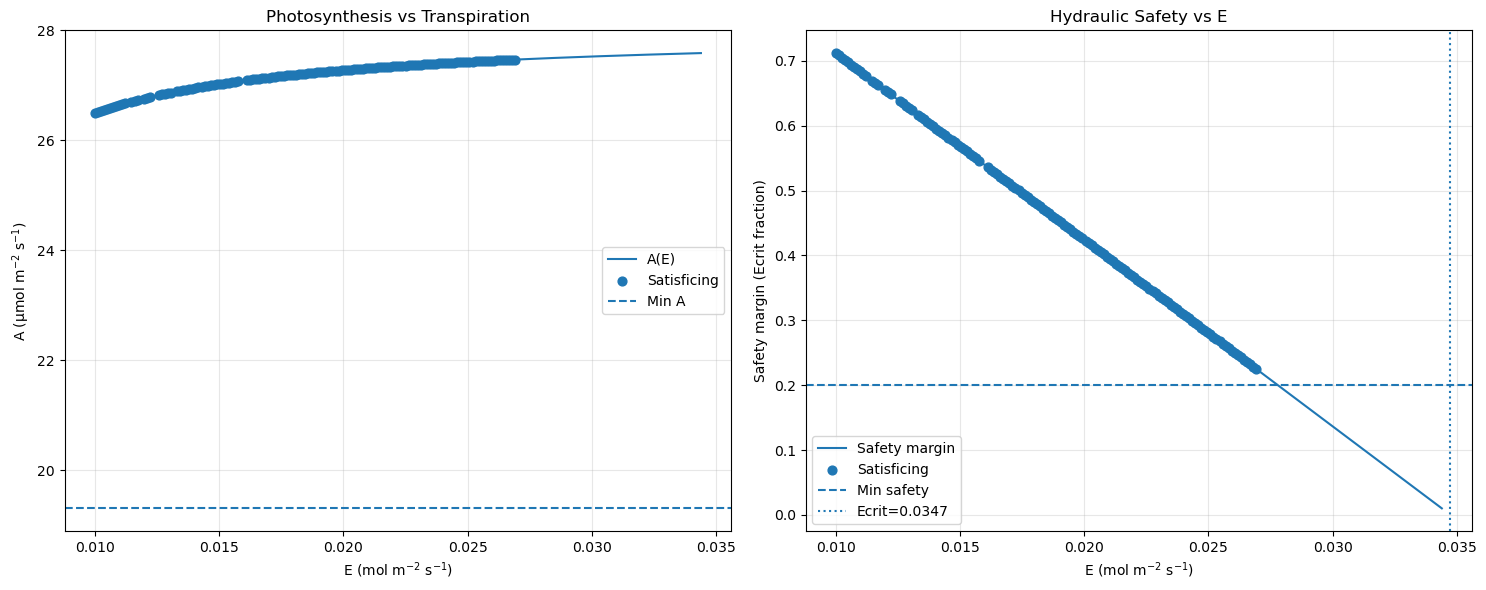

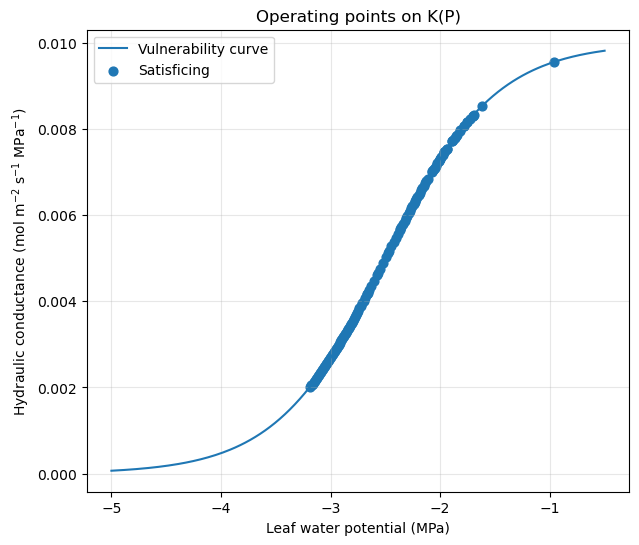

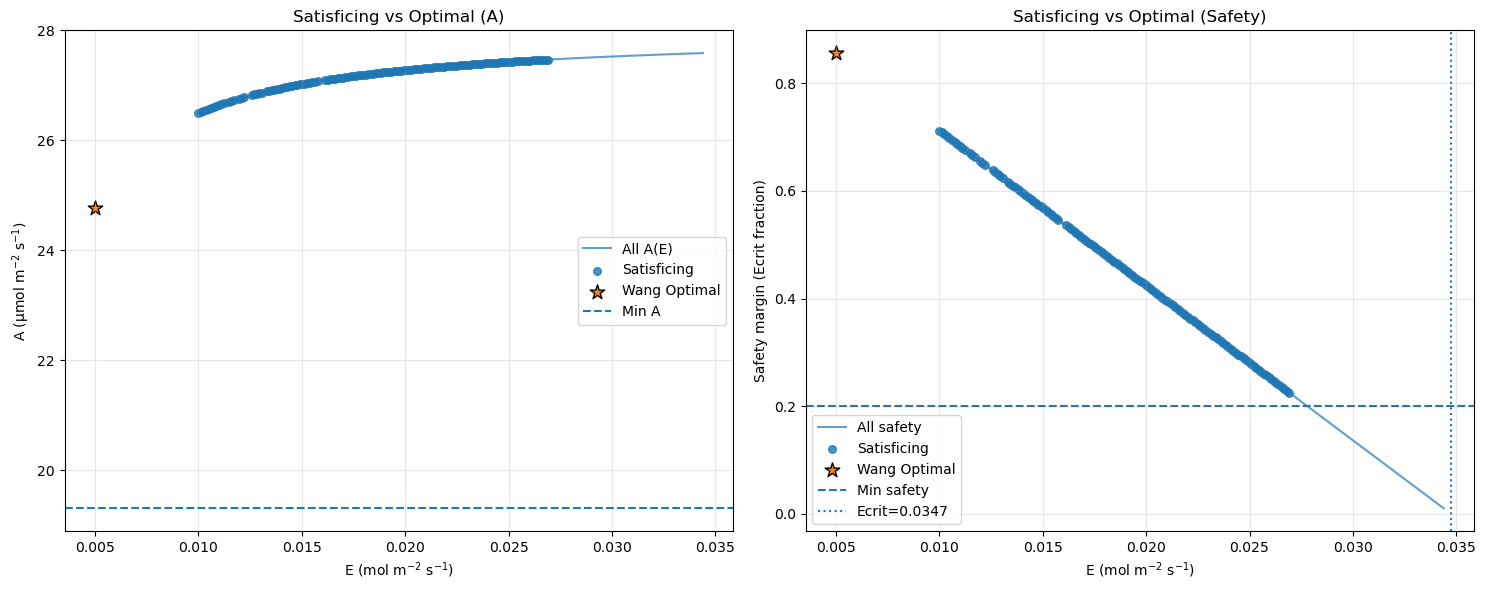

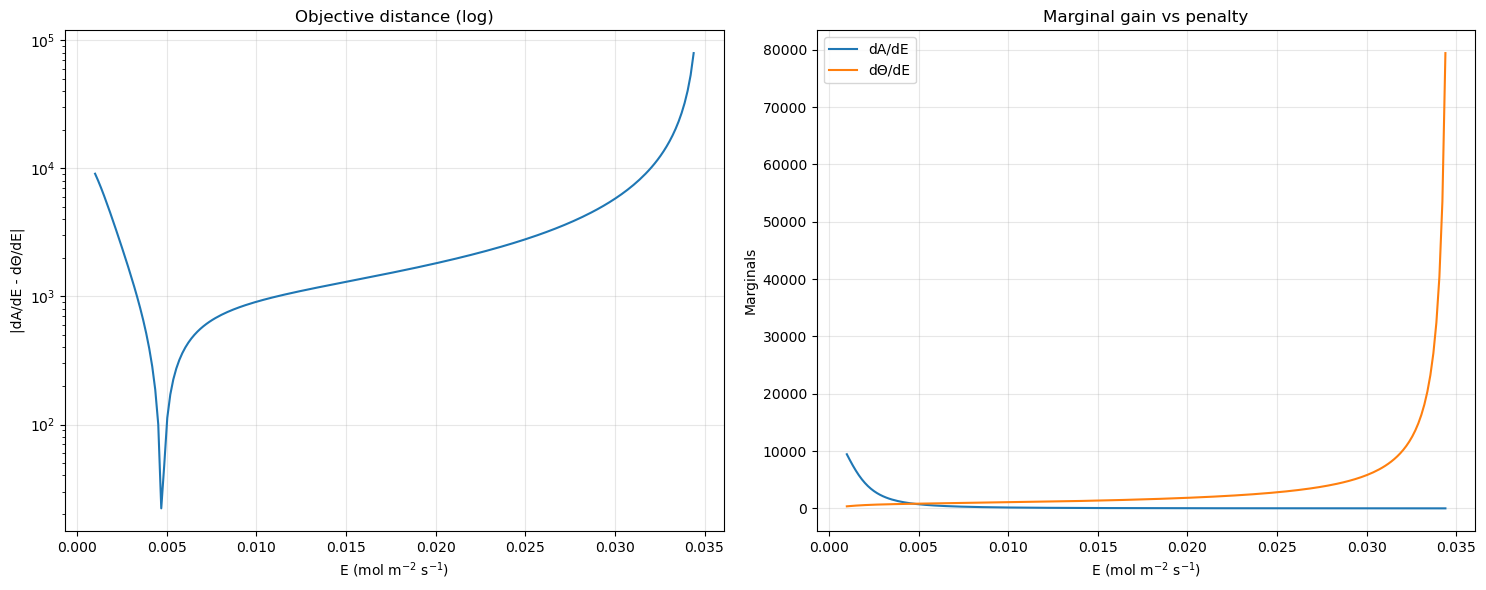

Minimum objective 2.215749e+01 at E=0.004692
dA/dE=838.311123, dΘ/dE=816.153635


In [31]:
### RUN THE FUNCTIONS for the droughted scenario

# -----------------------
# Run
# -----------------------
if __name__ == "__main__":
    Ecrit = E_crit(P_soil, P50, a, K_max, frac=0.05)
    print(f"Ecrit = {Ecrit:.6f} mol m^-2 s^-1")

    satis, wang, metrics, max_A, Ecrit = find_satisficing_solution()

    if satis:
        print(f"Found {len(satis)} satisficing solutions.")
        for i, s in enumerate(satis[:3]):
            print(f"  Sol {i+1}: E={s['E']:.5f}, A={s['A']:.2f} ({100*s['A']/max_A:.1f}% max), "
                  f"safety={100*s['safety_margin']:.1f}%, risk={100*s['hydraulic_risk']:.1f}%, "
                  f"Ci={s['Ci']:.1f}, Pleaf={s['P_leaf']:.3f} MPa")
    else:
        print("No satisficing solutions under current thresholds.")

    print(f"Max A = {max_A:.2f} μmol m^-2 s^-1")
    plot_satisficing_space(satis, metrics, max_A, Ecrit)

    # Vulnerability curve with operating points
    P_range = np.linspace(-0.5, -5.0, 200)
    K_range = hydraulic_conductance(P_range, P50, a, K_max)
    plt.figure(figsize=(7,6))
    plt.plot(P_range, K_range, label='Vulnerability curve')
    if satis:
        P_leaves = [m['P_leaf'] for m in satis]
        K_vals   = [m['K_current'] for m in satis]
        plt.scatter(P_leaves, K_vals, s=40, label='Satisficing')
    plt.xlabel('Leaf water potential (MPa)')
    plt.ylabel('Hydraulic conductance (mol m$^{-2}$ s$^{-1}$ MPa$^{-1}$)')
    plt.title('Operating points on K(P)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    plot_comparison(metrics, satis, wang, Ecrit, max_A)
    plot_objective_function(Ecrit)

In [32]:
# Constants

LAMBDA = 1.6       # diffusivity ratio H2O/CO2 (dimensionless)
PATM = 101.325     # kPa
Γ = 40.0           # CO2 compensation point (μmol mol^-1)
Ca = 400.0         # Atmospheric CO2 (μmol mol^-1)
VPD = 3          # kPa
D_unitless = VPD / PATM

# Photosynthetic params
Vcmax = 50       # μmol m^-2 s^-1
Jmax  = 100      # μmol m^-2 s^-1
Rd    = 1.0        # μmol m^-2 s^-1 (Dark respiration)

# Hydraulic params
P50   = -1      # MPa (Water potential at 50% loss of conductivity)
a     = 4.0        # unitless slope of vulnerability curve (Shape parameter for vulnerability curve)
K_max = 0.005       # mol m^-2 s^-1 MPa^-1 (Maximum hydraulic conductance)
P_soil = -1.5      # MPa (Soil water potential)

# Satisficing params
SAFETY_MARGIN = 0.2             # >= 20% of Ecrit remaining
MIN_PHOTOSYNTHESIS_RATIO = 0.7  # >= 70% of max A
SATISFICE_TOLERANCE = 0.1  # 10% tolerance for "good enough"

Ecrit = 0.001191 mol m^-2 s^-1
No satisficing solutions under current thresholds.
Max A = 16.53 μmol m^-2 s^-1


/tmp/ipykernel_1845019/2289072386.py:68: RuntimeWarning: overflow encountered in scalar power
  dVdP = (a * sig) / (1.0 + sig)**2


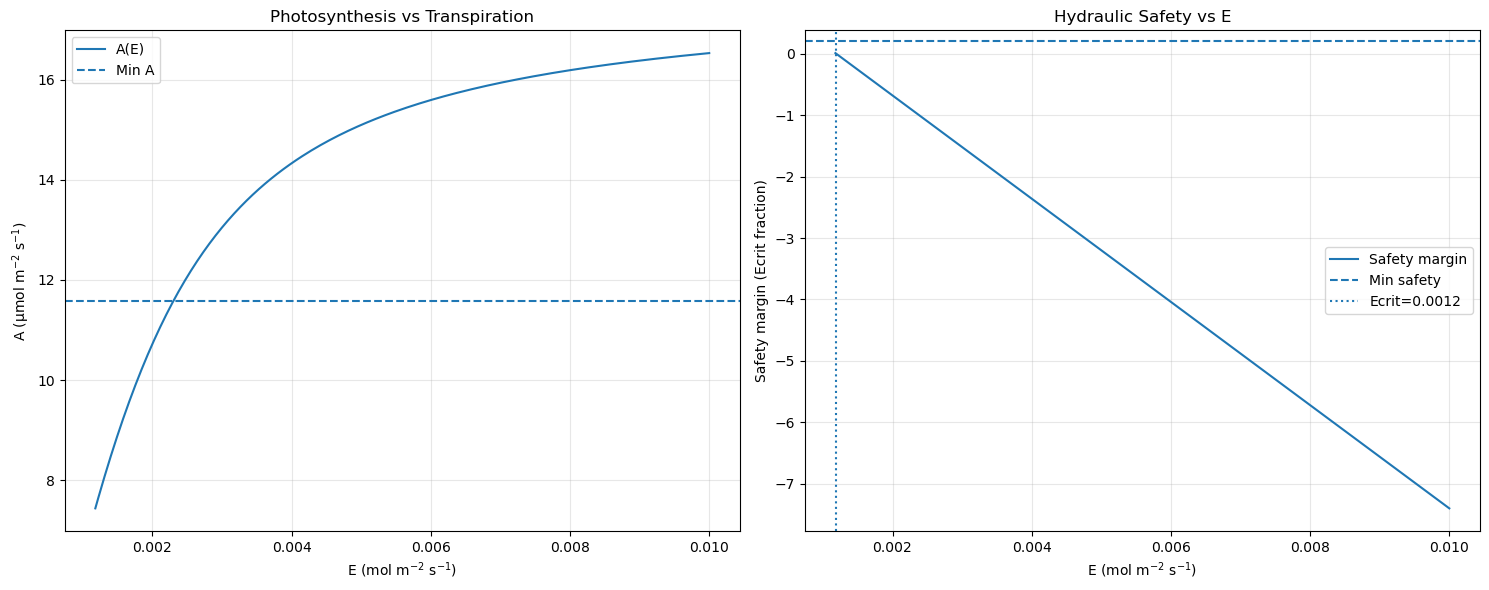

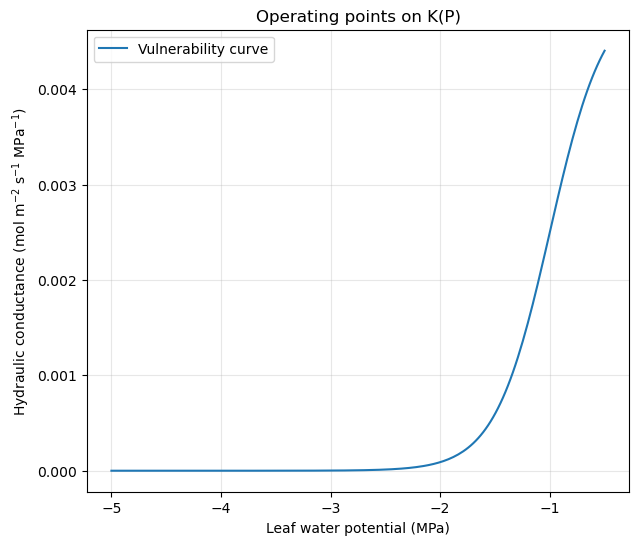

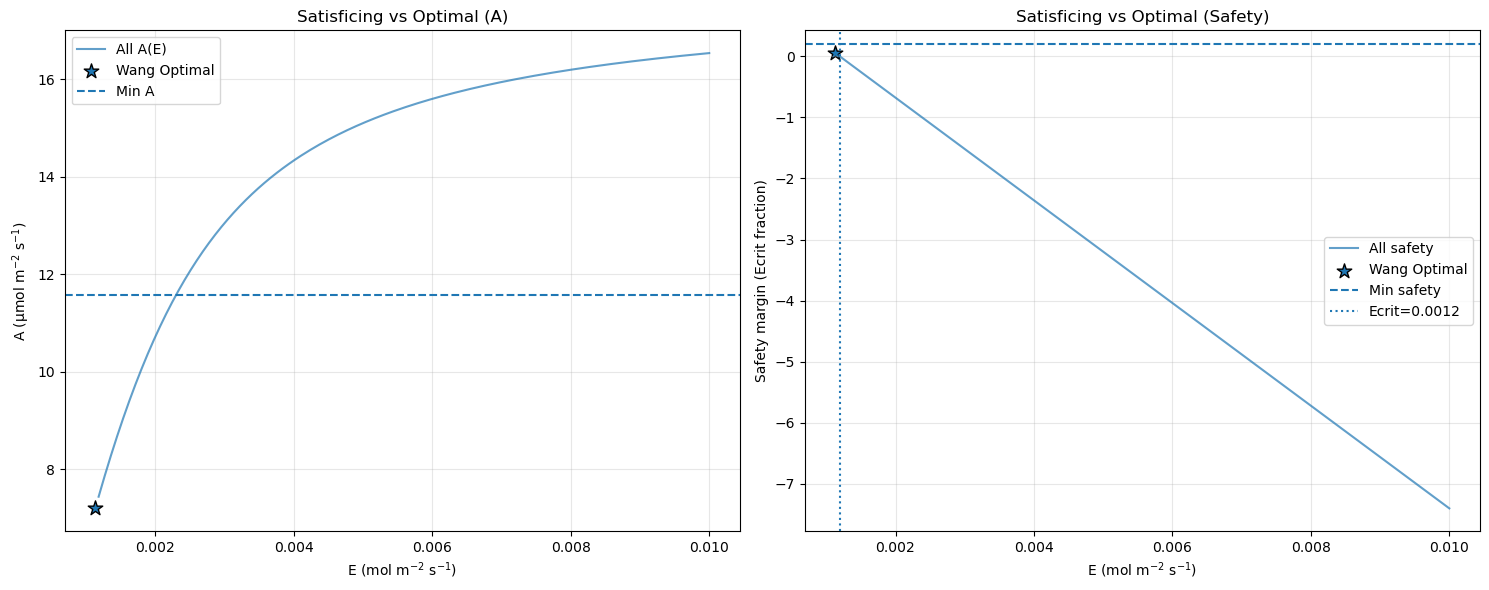

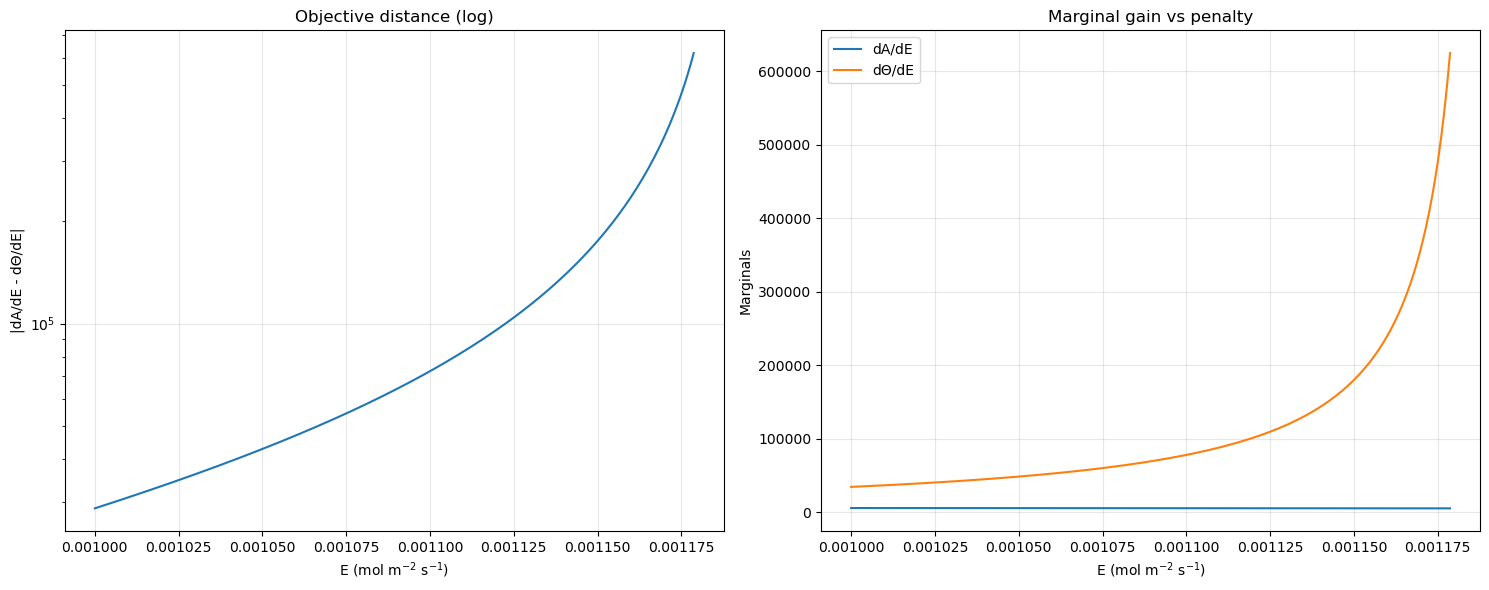

Minimum objective 2.876900e+04 at E=0.001000
dA/dE=5394.444718, dΘ/dE=34163.448480


In [33]:
####### Scenario with impossible-to-survive critera, aka plant is dying#######
# Code copy-paste (inefficient-- sorry to the CliMA software engineers)

# -----------------------
# Run
# -----------------------
if __name__ == "__main__":
    Ecrit = E_crit(P_soil, P50, a, K_max, frac=0.05)
    print(f"Ecrit = {Ecrit:.6f} mol m^-2 s^-1")

    satis, wang, metrics, max_A, Ecrit = find_satisficing_solution()

    if satis:
        print(f"Found {len(satis)} satisficing solutions.")
        for i, s in enumerate(satis[:3]):
            print(f"  Sol {i+1}: E={s['E']:.5f}, A={s['A']:.2f} ({100*s['A']/max_A:.1f}% max), "
                  f"safety={100*s['safety_margin']:.1f}%, risk={100*s['hydraulic_risk']:.1f}%, "
                  f"Ci={s['Ci']:.1f}, Pleaf={s['P_leaf']:.3f} MPa")
    else:
        print("No satisficing solutions under current thresholds.")

    print(f"Max A = {max_A:.2f} μmol m^-2 s^-1")
    plot_satisficing_space(satis, metrics, max_A, Ecrit)

    # Vulnerability curve with operating points
    P_range = np.linspace(-0.5, -5.0, 200)
    K_range = hydraulic_conductance(P_range, P50, a, K_max)
    plt.figure(figsize=(7,6))
    plt.plot(P_range, K_range, label='Vulnerability curve')
    if satis:
        P_leaves = [m['P_leaf'] for m in satis]
        K_vals   = [m['K_current'] for m in satis]
        plt.scatter(P_leaves, K_vals, s=40, label='Satisficing')
    plt.xlabel('Leaf water potential (MPa)')
    plt.ylabel('Hydraulic conductance (mol m$^{-2}$ s$^{-1}$ MPa$^{-1}$)')
    plt.title('Operating points on K(P)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    plot_comparison(metrics, satis, wang, Ecrit, max_A)
    plot_objective_function(Ecrit)